# Orders Analysis

This notebook analyzes order-level behavior in the Olist e-commerce dataset.

Objectives:
- Understand order volume trends over time
- Analyze order status distribution
- Evaluate delivery performance
- Create reusable metrics for downstream analysis

In [1]:
# Import necessary libraries
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
# Initialize BigQuery client
client = bigquery.Client(project="project-dsai-2025-11-12")

/home/taufiqidris/miniconda3/envs/elt/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
# Orders Analysis
query = """
SELECT
  order_id,
  customer_id,
  order_status,
  order_purchase_timestamp,
  order_approved_at,
  order_delivered_carrier_date,
  order_delivered_customer_date,
  order_estimated_delivery_date
FROM `project-dsai-2025-11-12.olist_stage.fct_orders`
"""

df_orders = client.query(query).to_dataframe()
df_orders.head()

/home/taufiqidris/miniconda3/envs/elt/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,bd35b677fd239386e9861d11ae98ab56,ad2eb5d02c0808bcd8743117f6383cf6,canceled,2018-09-17 17:21:16+00:00,NaT,NaT,NaT,2018-10-01 00:00:00+00:00
1,5f787bb3e0a01a4f347192157c036791,61954273c451808b32e15fb11dbf9116,canceled,2017-03-13 06:03:37+00:00,2017-03-13 06:03:37+00:00,NaT,NaT,2017-04-03 00:00:00+00:00
2,2aaab7e991347226dbda1f61c6785f88,55c72a24117236fa6e1e89bb2b4a02e0,canceled,2018-07-25 13:57:52+00:00,2018-07-25 15:10:12+00:00,NaT,NaT,2018-08-10 00:00:00+00:00
3,84002f994c72707b99788fbbc6f72f3f,da46ea1fd34482beef6ea70f81442d75,canceled,2018-06-29 09:20:04+00:00,2018-06-29 09:35:14+00:00,NaT,NaT,2018-07-23 00:00:00+00:00
4,24b425b6d0f061fcb84c1832d221e3bb,aeb4c7533882b7b165d846a5cb5a4c3e,canceled,2017-08-22 09:50:59+00:00,NaT,NaT,NaT,2017-09-26 00:00:00+00:00


In [3]:
# Check the shape of the orders dataframe
df_orders.shape

(99439, 8)

In [4]:
# Check the data types of the orders dataframe
df_orders.dtypes

order_id                                      object
customer_id                                   object
order_status                                  object
order_purchase_timestamp         datetime64[us, UTC]
order_approved_at                datetime64[us, UTC]
order_delivered_carrier_date     datetime64[us, UTC]
order_delivered_customer_date    datetime64[us, UTC]
order_estimated_delivery_date    datetime64[us, UTC]
dtype: object

In [5]:
# Convert date columns to datetime
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    df_orders[col] = pd.to_datetime(df_orders[col], utc=True)

In [6]:
# Check the data types after conversion
orders_monthly = (
    df_orders
    .set_index("order_purchase_timestamp")
    .resample("M")
    .agg(order_count=("order_id", "nunique"))
    .reset_index()
)

orders_monthly.head()

/tmp/ipykernel_112678/1898921418.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


,order_purchase_timestamp,order_count
0,2016-09-30 00:00:00+00:00,4
1,2016-10-31 00:00:00+00:00,324
2,2016-11-30 00:00:00+00:00,0
3,2016-12-31 00:00:00+00:00,1
4,2017-01-31 00:00:00+00:00,800


In [29]:
# Monthly counts with month start frequency
orders_monthly = (
    df_orders
    .set_index("order_purchase_timestamp")
    .resample("MS")  # Month Start frequency
    .size()
    .reset_index()
    .rename(columns={0: "order_count"})
)

# Create a COMPLETE monthly range between min and max month
full_months = pd.date_range(
    start=orders_monthly["order_purchase_timestamp"].min(),
    end=orders_monthly["order_purchase_timestamp"].max(),
    freq="MS"
)

# Reindex to fill missing months
orders_monthly_complete = orders_monthly.set_index("order_purchase_timestamp").reindex(full_months)

# Fill missing months with 0 orders
orders_monthly_complete["order_count"] = orders_monthly_complete["order_count"].fillna(0).astype(int)
orders_monthly = orders_monthly_complete.reset_index()

# Optional: drop the last month if it's clearly partial (often causes the big drop)
if len(orders_monthly) >= 2 and orders_monthly["order_count"].iloc[-1] < 0.2 * orders_monthly["order_count"].iloc[-2]:
    orders_monthly = orders_monthly.iloc[:-1]

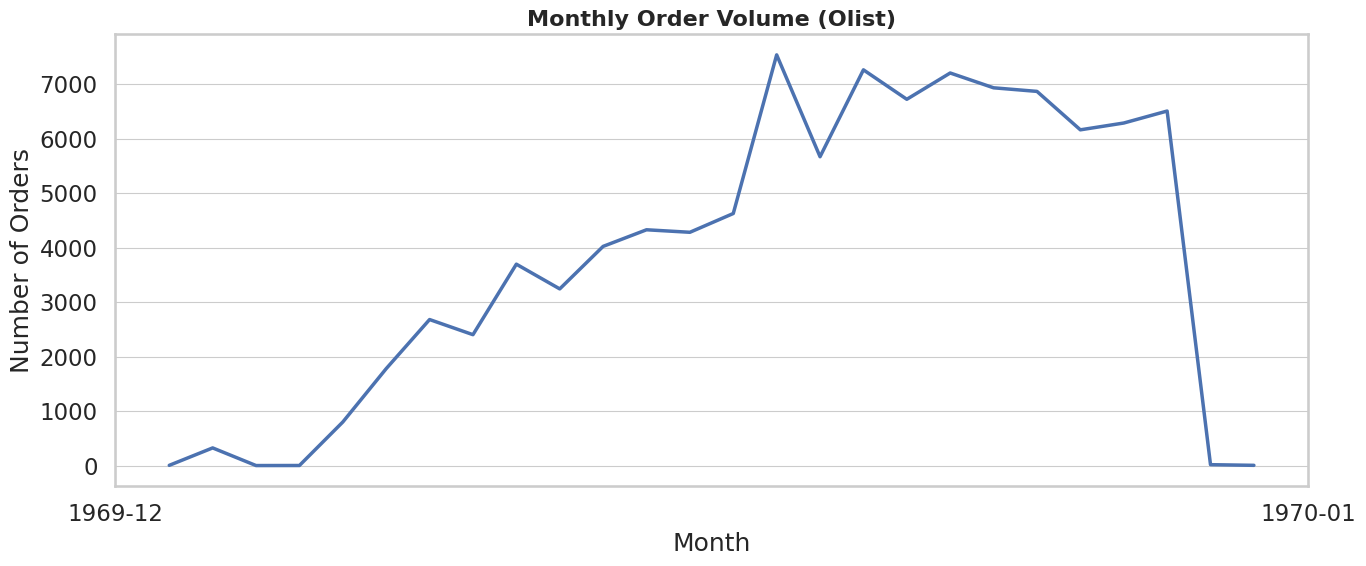

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

x = orders_monthly.index
y = orders_monthly["order_count"]

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(x, y, linewidth=2.5)

ax.set_title("Monthly Order Volume (Olist)", fontsize=16, weight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Orders")

# Major ticks: every quarter; Minor ticks: every month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Make grid professional: major grid only
ax.grid(True, which="major", axis="both", linewidth=0.8)
ax.grid(False, which="minor", axis="both")

# Reduce label clutter
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

fig.tight_layout()
plt.show()

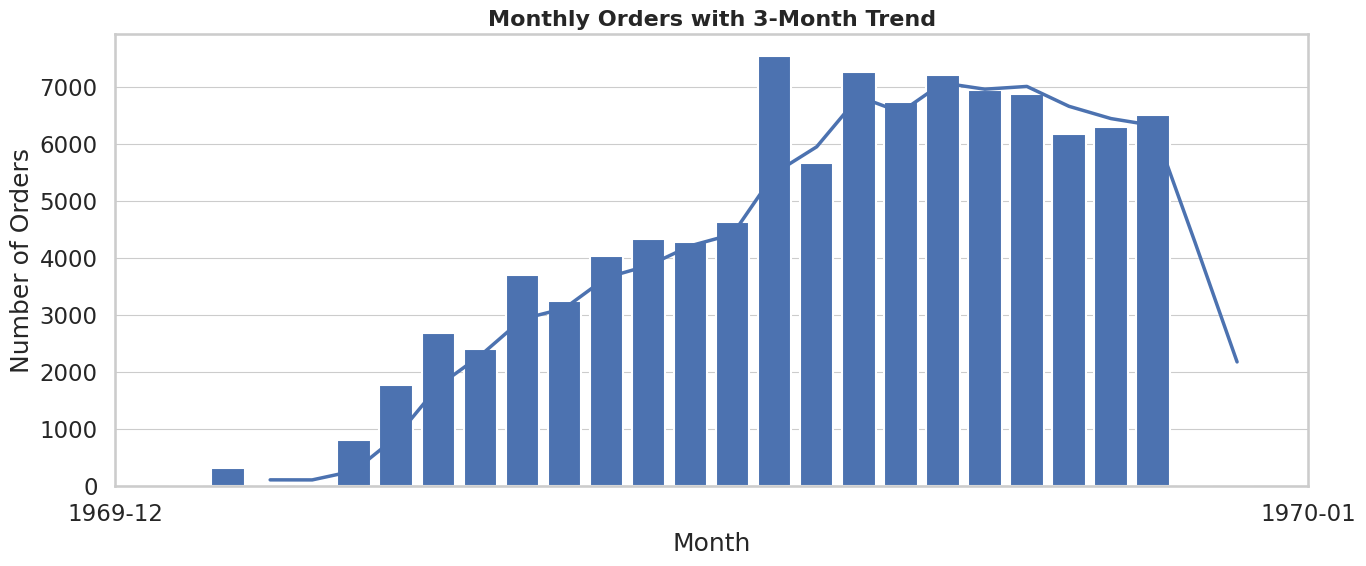

In [31]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(x, y)                       # monthly volume
ax.plot(x, y.rolling(3).mean(), linewidth=2.5)  # 3M trend

ax.set_title("Monthly Orders with 3-Month Trend", fontsize=16, weight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Orders")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.grid(True, which="major", axis="y", linewidth=0.8)
ax.grid(False, axis="x")

fig.tight_layout()
plt.show()

In [8]:
order_status_dist = (
    df_orders["order_status"]
    .value_counts(normalize=True)
    .reset_index()
    .rename(columns={"index": "order_status", "order_status": "share"})
)

order_status_dist

,share,proportion
0,delivered,0.970203
1,shipped,0.011132
2,canceled,0.006285
3,unavailable,0.006124
4,invoiced,0.003158
5,processing,0.003027
6,created,0.000050
7,approved,0.000020


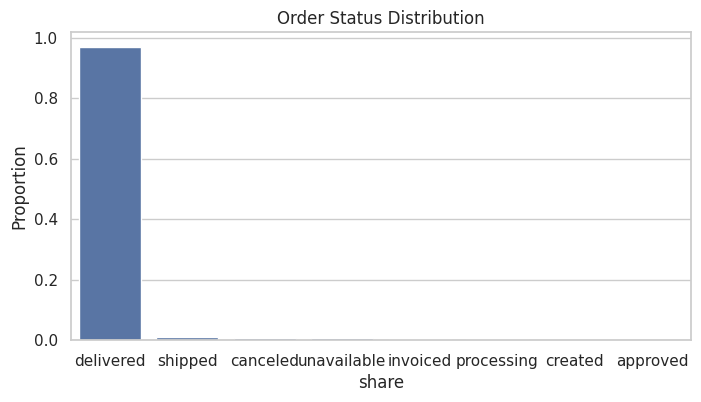

In [12]:
plt.figure(figsize=(8,4))
sns.barplot(
    data=order_status_dist,
    x="share",
    y="proportion"
)
plt.title("Order Status Distribution")
plt.ylabel("Proportion")
plt.show()

In [13]:
df_orders["delivery_days"] = (
    df_orders["order_delivered_customer_date"]
    - df_orders["order_purchase_timestamp"]
).dt.days

In [14]:
df_orders["delivery_days"].describe()

count    96474.000000
mean        12.094170
std          9.551827
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: delivery_days, dtype: float64

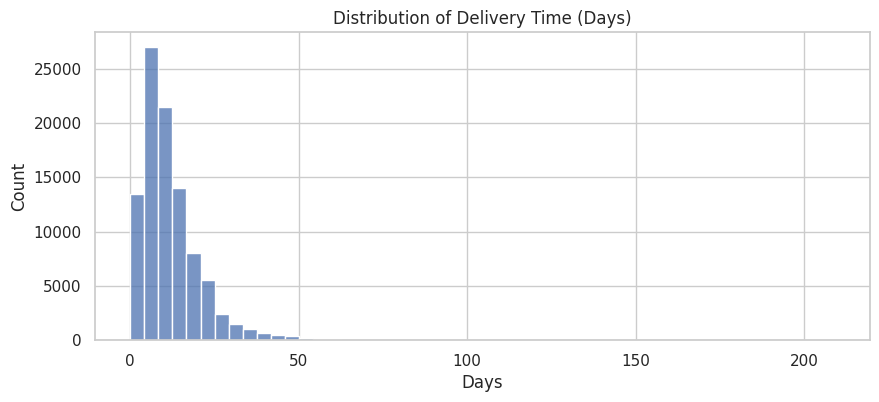

In [15]:
plt.figure(figsize=(10,4))
sns.histplot(
    df_orders["delivery_days"].dropna(),
    bins=50
)
plt.title("Distribution of Delivery Time (Days)")
plt.xlabel("Days")
plt.show()

In [16]:
df_orders["is_late"] = (
    df_orders["order_delivered_customer_date"]
    > df_orders["order_estimated_delivery_date"]
)

In [17]:
df_orders["is_late"].value_counts(normalize=True)

is_late
False    0.921288
True     0.078712
Name: proportion, dtype: float64

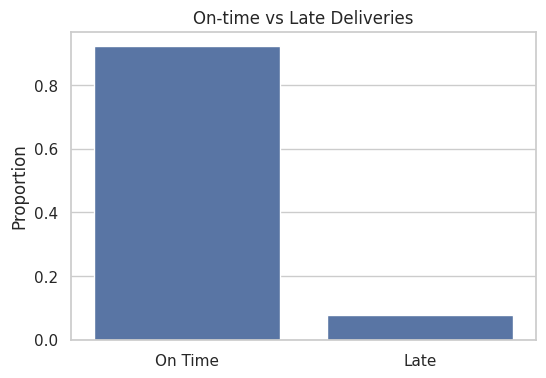

In [18]:
plt.figure(figsize=(6,4))
sns.barplot(
    x=["On Time", "Late"],
    y=[
        (~df_orders["is_late"]).mean(),
        df_orders["is_late"].mean()
    ]
)
plt.title("On-time vs Late Deliveries")
plt.ylabel("Proportion")
plt.show()

In [19]:
orders_per_customer = (
    df_orders
    .groupby("customer_id")
    .agg(order_count=("order_id", "nunique"))
)

orders_per_customer.describe()

,order_count
count,99439.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


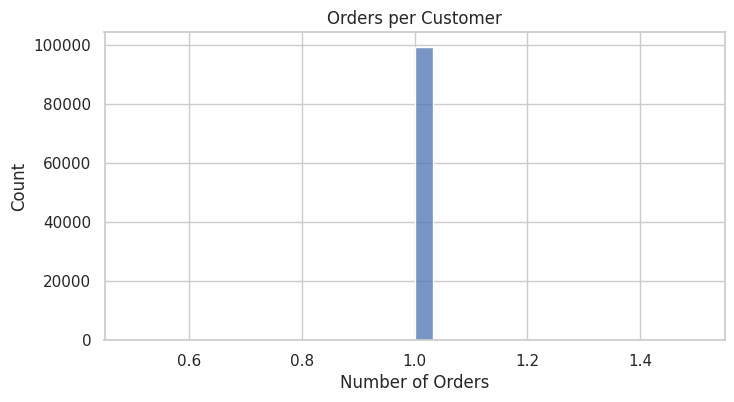

In [20]:
plt.figure(figsize=(8,4))
sns.histplot(
    orders_per_customer["order_count"],
    bins=30
)
plt.title("Orders per Customer")
plt.xlabel("Number of Orders")
plt.show()